# Three Qubit Quantum Autoencoder

From https://arxiv.org/pdf/2202.00555.pdf and https://www.tensorflow.org/quantum/tutorials/qcnn?hl=en

In [ ]:
!pip install cirq

In [ ]:
!pip install tensorflow==2.7.0

In [ ]:
!pip install tensorflow-quantum

In [5]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [6]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import random

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

In [7]:
# Right now states  are |0>L and |1>L (TODO add |+> and |-> => Just train on |-> as paper suggested)
def getValidStates(qubits):
    return [ #|0>L
             { 'circuit': [cirq.I(qubits[0]), cirq.I(qubits[1]), cirq.I(qubits[2])], 'bit': [0,0,0] }, 
             { 'circuit': [cirq.X(qubits[0]), cirq.I(qubits[1]), cirq.I(qubits[2])], 'bit': [0,0,0] }, 
             { 'circuit': [cirq.I(qubits[0]), cirq.X(qubits[1]), cirq.I(qubits[2])], 'bit': [0,0,0] }, 
             { 'circuit': [cirq.I(qubits[0]), cirq.I(qubits[1]), cirq.X(qubits[2])], 'bit': [0,0,0] },
             # |1>L
             { 'circuit': [cirq.X(qubits[0]), cirq.X(qubits[1]), cirq.X(qubits[2])], 'bit': [1,1,1] },
             { 'circuit': [cirq.I(qubits[0]), cirq.X(qubits[1]), cirq.X(qubits[2])], 'bit': [1,1,1] },
             { 'circuit': [cirq.X(qubits[0]), cirq.I(qubits[1]), cirq.X(qubits[2])], 'bit': [1,1,1] },
             { 'circuit': [cirq.X(qubits[0]), cirq.X(qubits[1]), cirq.I(qubits[2])], 'bit': [1,1,1] },
           ] 

def generate_data(qubits):
    """Generate training and testing data."""
    validStates = getValidStates(qubits)
    n_rounds = 1000
    excitations = []
    labels = []
    rng = np.random.default_rng()
    for n in range(n_rounds):
      circuit = cirq.Circuit()
      indx = rng.integers(0, len(validStates), size=1)[0]
      theState = validStates[indx]['circuit']
      theLabel = validStates[indx]['bit']
      for op in theState:
        circuit.append(op)
      excitations.append(circuit)
      labels.append(theLabel)
      #(TODO use errors from https://github.com/tensorflow/quantum/issues/250 ??)

    split_ind = int(len(excitations) * 0.7)
    train_excitations = excitations[:split_ind]
    test_excitations = excitations[split_ind:]

    train_labels = labels[:split_ind]
    test_labels = labels[split_ind:]

    return tfq.convert_to_tensor(train_excitations), np.array(train_labels), \
        tfq.convert_to_tensor(test_excitations), np.array(test_labels)

In [ ]:
sample_points, sample_labels, _, __ = generate_data(cirq.GridQubit.rect(1, 4))
for i in range(0, 20):
  print('Input:', tfq.from_tensor(sample_points)[i], 'Output:', sample_labels[i])

In [8]:
# 3-1-3 QAE
def create_model_circuit(qubits):
    model_circuit = cirq.Circuit()

    symbols = sympy.symbols('qconv0:30')

    uCircuit = cirq.Circuit()
    uCircuit.append(cirq.ry(symbols[0])(qubits[0]))
    uCircuit.append(cirq.ry(symbols[1])(qubits[1]))
    uCircuit.append(cirq.ry(symbols[2])(qubits[2]))
    uCircuit.append(cirq.ry(symbols[3])(qubits[3]))
    uCircuit.append(cirq.rz(symbols[4])(qubits[0]))
    uCircuit.append(cirq.rz(symbols[5])(qubits[1]))
    uCircuit.append(cirq.rz(symbols[6])(qubits[2]))
    uCircuit.append(cirq.rz(symbols[7])(qubits[3]))
    uCircuit.append(cirq.CNOT(qubits[0], qubits[1])**symbols[8])
    uCircuit.append(cirq.CNOT(qubits[1], qubits[2])**symbols[9])
    uCircuit.append(cirq.CNOT(qubits[2], qubits[3])**symbols[10])
    uCircuit.append(cirq.rz(symbols[11])(qubits[0]))
    uCircuit.append(cirq.rz(symbols[12])(qubits[1]))
    uCircuit.append(cirq.rz(symbols[13])(qubits[2]))
    uCircuit.append(cirq.rz(symbols[14])(qubits[3]))
    model_circuit.append(uCircuit)

    uTransposeCircuit = cirq.Circuit()
    uTransposeCircuit.append(cirq.ry(symbols[15])(qubits[4]))
    uTransposeCircuit.append(cirq.ry(symbols[16])(qubits[5]))
    uTransposeCircuit.append(cirq.ry(symbols[17])(qubits[6]))
    uTransposeCircuit.append(cirq.ry(symbols[18])(qubits[3]))
    uTransposeCircuit.append(cirq.rz(symbols[19])(qubits[4]))
    uTransposeCircuit.append(cirq.rz(symbols[20])(qubits[5]))
    uTransposeCircuit.append(cirq.rz(symbols[21])(qubits[6]))
    uTransposeCircuit.append(cirq.rz(symbols[22])(qubits[3]))
    uTransposeCircuit.append(cirq.CNOT(qubits[4], qubits[5])**symbols[23])
    uTransposeCircuit.append(cirq.CNOT(qubits[5], qubits[6])**symbols[24])
    uTransposeCircuit.append(cirq.CNOT(qubits[6], qubits[3])**symbols[25])
    uTransposeCircuit.append(cirq.rz(symbols[26])(qubits[4]))
    uTransposeCircuit.append(cirq.rz(symbols[27])(qubits[5]))
    uTransposeCircuit.append(cirq.rz(symbols[28])(qubits[6]))
    uTransposeCircuit.append(cirq.rz(symbols[29])(qubits[3]))
    uTransposeCircuit = cirq.inverse(uTransposeCircuit)   
    model_circuit.append(uTransposeCircuit)

    SVGCircuit(model_circuit)

    return model_circuit

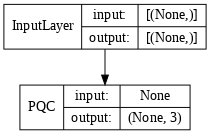

In [9]:
# Create our qubits and readout operators in Cirq.
out_state_bits = cirq.GridQubit.rect(1, 7)
readout_operators = [cirq.Z(out_state_bits[4]), cirq.Z(out_state_bits[5]), cirq.Z(out_state_bits[6])]

excitation_input = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

quantum_model = tfq.layers.PQC(create_model_circuit(out_state_bits),
                               readout_operators,
                               differentiator=tfq.differentiators.Adjoint())(excitation_input)

qcnn_model = tf.keras.Model(inputs=[excitation_input], outputs=[quantum_model])

# Show the keras plot of the model
tf.keras.utils.plot_model(qcnn_model,
                          show_shapes=True,
                          show_layer_names=False,
                          dpi=70)

In [10]:
# Generate some training data.
train_excitations, train_labels, test_excitations, test_labels = generate_data(
    out_state_bits[:3])

# Custom accuracy metric.
def mapResult(x):
  #tf.print(x)
  return tf.map_fn(lambda y: 0.0 if y >= 0 else 1.0, x)
def custom_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true)
    y_pred = tf.map_fn(lambda x: mapResult(x), y_pred)
    return tf.keras.backend.mean(tf.keras.backend.equal(y_true, y_pred))


qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.02),
                   loss=tf.losses.mse,
                   metrics=[custom_accuracy])

history = qcnn_model.fit(x=train_excitations,
                         y=train_labels,
                         batch_size=16,
                         epochs=25,
                         verbose=1,
                         validation_data=(test_excitations, test_labels))

Epoch 1/25
44/44 [==============================] - 4s 57ms/step - loss: 0.9114 - custom_accuracy: 0.5123 - val_loss: 0.6127 - val_custom_accuracy: 0.4737
Epoch 2/25
44/44 [==============================] - 2s 55ms/step - loss: 0.3536 - custom_accuracy: 0.5104 - val_loss: 0.2735 - val_custom_accuracy: 0.4211
Epoch 3/25
44/44 [==============================] - 2s 56ms/step - loss: 0.2521 - custom_accuracy: 0.5213 - val_loss: 0.2548 - val_custom_accuracy: 0.4211
Epoch 4/25
44/44 [==============================] - 3s 72ms/step - loss: 0.2507 - custom_accuracy: 0.5208 - val_loss: 0.2561 - val_custom_accuracy: 0.4211
Epoch 5/25
44/44 [==============================] - 2s 57ms/step - loss: 0.2501 - custom_accuracy: 0.5208 - val_loss: 0.2518 - val_custom_accuracy: 0.4211
Epoch 6/25
44/44 [==============================] - 3s 79ms/step - loss: 0.2499 - custom_accuracy: 0.5213 - val_loss: 0.2556 - val_custom_accuracy: 0.4211
Epoch 7/25
44/44 [==============================] - 3s 69ms/step - los

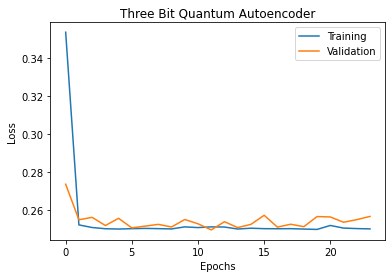

In [11]:
plt.plot(history.history['loss'][1:], label='Training')
plt.plot(history.history['val_loss'][1:], label='Validation')
plt.title('Three Bit Quantum Autoencoder')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()